In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from geopy.distance import geodesic
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *


# Reading Train and Test data

In [2]:
train_data=pd.read_csv("D:/datasets/credit_card_fraud_detection/fraudTrain.csv")
test_data=pd.read_csv("D:/datasets/credit_card_fraud_detection/fraudTest.csv")
train_data.head(5)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


# Data clearing and filtering

In [3]:
print(train_data.columns)
print(test_data.columns)

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')
Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')


## Checking the size of genuine vs fraud data

In [4]:
fraud_check=train_data["is_fraud"].value_counts().tolist()
fraud_check

[1289169, 7506]

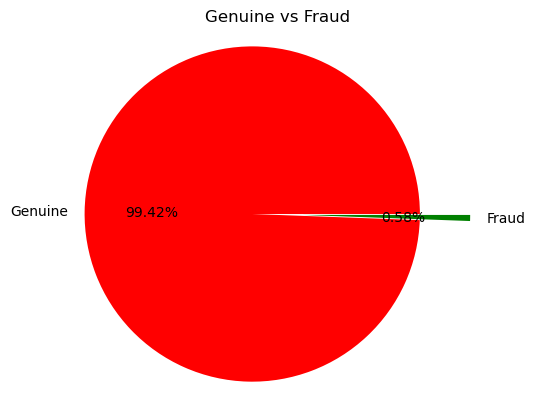

In [5]:
Labels=['Genuine','Fraud']
plt.pie(train_data["is_fraud"].value_counts(),labels=Labels,colors=['Red','Green'],explode=(0.1,0.2),autopct='%1.2f%%')
plt.axis('equal')
plt.title('Genuine vs Fraud')
plt.show()

## Cleaning data

In [6]:
print(f"train_data:{train_data.isna().sum()}")
print(f"test_data:{test_data.isna().sum()}")

train_data:Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64
test_data:Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                  

In [7]:
print(train_data.duplicated().sum())
print(test_data.duplicated().sum())

0
0


In [8]:
print(train_data["merchant"].head(10))
print(test_data["merchant"].head(10))

0            fraud_Rippin, Kub and Mann
1       fraud_Heller, Gutmann and Zieme
2                  fraud_Lind-Buckridge
3    fraud_Kutch, Hermiston and Farrell
4                   fraud_Keeling-Crist
5      fraud_Stroman, Hudson and Erdman
6                 fraud_Rowe-Vandervort
7                  fraud_Corwin-Collins
8                      fraud_Herzog Ltd
9     fraud_Schoen, Kuphal and Nitzsche
Name: merchant, dtype: object
0                   fraud_Kirlin and Sons
1                    fraud_Sporer-Keebler
2    fraud_Swaniawski, Nitzsche and Welch
3                       fraud_Haley Group
4                   fraud_Johnston-Casper
5                     fraud_Daugherty LLC
6                     fraud_Romaguera Ltd
7                       fraud_Reichel LLC
8       fraud_Goyette, Howell and Collier
9                     fraud_Kilback Group
Name: merchant, dtype: object


### removing 'fraud_' from merchant

In [9]:
train_data["merchant"]=train_data["merchant"].apply(lambda x: x.replace("fraud_",""))
test_data["merchant"]=test_data["merchant"].apply(lambda x: x.replace("fraud_",""))
print(f"{train_data[['merchant']].head()}")
print("\n")
print(f"{test_data[['merchant']].head()}")     

                       merchant
0          Rippin, Kub and Mann
1     Heller, Gutmann and Zieme
2                Lind-Buckridge
3  Kutch, Hermiston and Farrell
4                 Keeling-Crist


                         merchant
0                 Kirlin and Sons
1                  Sporer-Keebler
2  Swaniawski, Nitzsche and Welch
3                     Haley Group
4                 Johnston-Casper


In [10]:
train_data['split']= 'train'
test_data['split']='test'
data=pd.concat([train_data,test_data],axis=0).reset_index(drop=True)
data.tail(5)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,split
1852389,555714,2020-12-31 23:59:07,30560609640617,Reilly and Sons,health_fitness,43.77,Michael,Olson,M,558 Michael Estates,...,-91.8912,519,Town planner,1966-02-13,9b1f753c79894c9f4b71f04581835ada,1388534347,39.946837,-91.333331,0,test
1852390,555715,2020-12-31 23:59:09,3556613125071656,Hoppe-Parisian,kids_pets,111.84,Jose,Vasquez,M,572 Davis Mountains,...,-95.4401,28739,Futures trader,1999-12-27,2090647dac2c89a1d86c514c427f5b91,1388534349,29.661049,-96.186633,0,test
1852391,555716,2020-12-31 23:59:15,6011724471098086,Rau-Robel,kids_pets,86.88,Ann,Lawson,F,144 Evans Islands Apt. 683,...,-118.9017,3684,Musician,1981-11-29,6c5b7c8add471975aa0fec023b2e8408,1388534355,46.658340,-119.715054,0,test
1852392,555717,2020-12-31 23:59:24,4079773899158,Breitenberg LLC,travel,7.99,Eric,Preston,M,7020 Doyle Stream Apt. 951,...,-116.4493,129,Cartographer,1965-12-15,14392d723bb7737606b2700ac791b7aa,1388534364,44.470525,-117.080888,0,test
1852393,555718,2020-12-31 23:59:34,4170689372027579,Dare-Marvin,entertainment,38.13,Samuel,Frey,M,830 Myers Plaza Apt. 384,...,-97.4798,116001,Media buyer,1993-05-10,1765bb45b3aa3224b4cdcb6e7a96cee3,1388534374,36.210097,-97.036372,0,test


In [11]:
print(data.isnull().sum())


Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
split                    0
dtype: int64


In [12]:
test_data.tail(5)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,split
555714,555714,2020-12-31 23:59:07,30560609640617,Reilly and Sons,health_fitness,43.77,Michael,Olson,M,558 Michael Estates,...,-91.8912,519,Town planner,1966-02-13,9b1f753c79894c9f4b71f04581835ada,1388534347,39.946837,-91.333331,0,test
555715,555715,2020-12-31 23:59:09,3556613125071656,Hoppe-Parisian,kids_pets,111.84,Jose,Vasquez,M,572 Davis Mountains,...,-95.4401,28739,Futures trader,1999-12-27,2090647dac2c89a1d86c514c427f5b91,1388534349,29.661049,-96.186633,0,test
555716,555716,2020-12-31 23:59:15,6011724471098086,Rau-Robel,kids_pets,86.88,Ann,Lawson,F,144 Evans Islands Apt. 683,...,-118.9017,3684,Musician,1981-11-29,6c5b7c8add471975aa0fec023b2e8408,1388534355,46.658340,-119.715054,0,test
555717,555717,2020-12-31 23:59:24,4079773899158,Breitenberg LLC,travel,7.99,Eric,Preston,M,7020 Doyle Stream Apt. 951,...,-116.4493,129,Cartographer,1965-12-15,14392d723bb7737606b2700ac791b7aa,1388534364,44.470525,-117.080888,0,test
555718,555718,2020-12-31 23:59:34,4170689372027579,Dare-Marvin,entertainment,38.13,Samuel,Frey,M,830 Myers Plaza Apt. 384,...,-97.4798,116001,Media buyer,1993-05-10,1765bb45b3aa3224b4cdcb6e7a96cee3,1388534374,36.210097,-97.036372,0,test


# Estabilishing relationships between data

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 24 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   trans_date_trans_time  object 
 2   cc_num                 int64  
 3   merchant               object 
 4   category               object 
 5   amt                    float64
 6   first                  object 
 7   last                   object 
 8   gender                 object 
 9   street                 object 
 10  city                   object 
 11  state                  object 
 12  zip                    int64  
 13  lat                    float64
 14  long                   float64
 15  city_pop               int64  
 16  job                    object 
 17  dob                    object 
 18  trans_num              object 
 19  unix_time              int64  
 20  merch_lat              float64
 21  merch_long             float64
 22  is_fraud          

In [14]:
# convert  datatype of trans_date_trans_time to date format
data['trans_date_trans_time']=pd.to_datetime(data['trans_date_trans_time'])#format='%y-%m-%d %H:%M:%S',errors='coerce')
data['trans_date_trans_time'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1852394 entries, 0 to 1852393
Series name: trans_date_trans_time
Non-Null Count    Dtype         
--------------    -----         
1852394 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 14.1 MB


In [15]:
data['trans_date_trans_time'].head(5)

0   2019-01-01 00:00:18
1   2019-01-01 00:00:44
2   2019-01-01 00:00:51
3   2019-01-01 00:01:16
4   2019-01-01 00:03:06
Name: trans_date_trans_time, dtype: datetime64[ns]

In [16]:
data['dob']=pd.to_datetime(data['dob'])
data['dob'].head(5)

0   1988-03-09
1   1978-06-21
2   1962-01-19
3   1967-01-12
4   1986-03-28
Name: dob, dtype: datetime64[ns]

In [17]:
#age of customer
data['age']=(data['trans_date_trans_time']-data['dob']).astype('<m8[Y]')
data['age'].head()

0    30.0
1    40.0
2    56.0
3    51.0
4    32.0
Name: age, dtype: float64

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 25 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Unnamed: 0             int64         
 1   trans_date_trans_time  datetime64[ns]
 2   cc_num                 int64         
 3   merchant               object        
 4   category               object        
 5   amt                    float64       
 6   first                  object        
 7   last                   object        
 8   gender                 object        
 9   street                 object        
 10  city                   object        
 11  state                  object        
 12  zip                    int64         
 13  lat                    float64       
 14  long                   float64       
 15  city_pop               int64         
 16  job                    object        
 17  dob                    datetime64[ns]
 18  trans_num             

In [19]:
data['year']=data['trans_date_trans_time'].dt.year
data['month']=data['trans_date_trans_time'].dt.month
data['day']=data['trans_date_trans_time'].dt.day
data['hour']=data['trans_date_trans_time'].dt.hour
data['name_of_day']=data['trans_date_trans_time'].dt.day_name()
data['week_day']=data['trans_date_trans_time'].dt.weekday
data['year'].value_counts()

2020    927544
2019    924850
Name: year, dtype: int64

In [20]:
#we have only data of only two years so the year is not relevant
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 31 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Unnamed: 0             int64         
 1   trans_date_trans_time  datetime64[ns]
 2   cc_num                 int64         
 3   merchant               object        
 4   category               object        
 5   amt                    float64       
 6   first                  object        
 7   last                   object        
 8   gender                 object        
 9   street                 object        
 10  city                   object        
 11  state                  object        
 12  zip                    int64         
 13  lat                    float64       
 14  long                   float64       
 15  city_pop               int64         
 16  job                    object        
 17  dob                    datetime64[ns]
 18  trans_num             

In [21]:
data['age'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1852394 entries, 0 to 1852393
Series name: age
Non-Null Count    Dtype  
--------------    -----  
1852394 non-null  float64
dtypes: float64(1)
memory usage: 14.1 MB


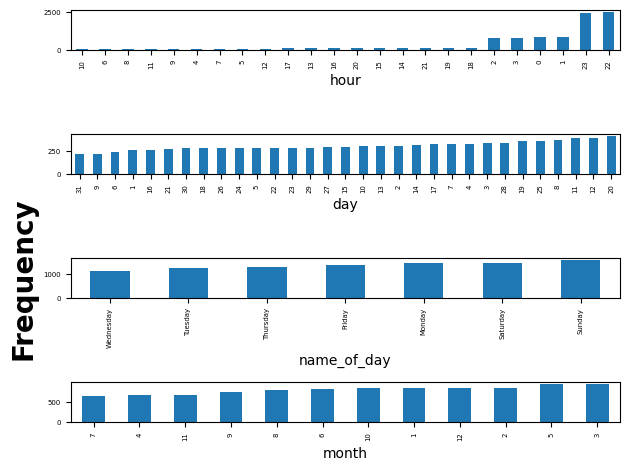

In [22]:
#histogram for month,days,hour and name_of_day
fig,axs = plt.subplots(4)
plt.subplots_adjust(hspace=1)

data.loc[data['is_fraud'] ==1 ,'hour'].value_counts(ascending=True).plot(kind='bar',ax=axs[0],fontsize=5)
axs[0].set_xlabel('hour')

data.loc[data['is_fraud'] ==1 ,'day'].value_counts(ascending=True).plot(kind='bar',ax=axs[1],fontsize=5)
axs[1].set_xlabel('day')

data.loc[data['is_fraud'] ==1 ,'name_of_day'].value_counts(ascending=True).plot(kind='bar',ax=axs[2],fontsize=5)
axs[2].set_xlabel('name_of_day')
axs[2].set_ylabel('Frequency',fontsize=20,fontweight='bold')

data.loc[data['is_fraud'] ==1 ,'month'].value_counts(ascending=True).plot(kind='bar',ax=axs[3],fontsize=5)
axs[3].set_xlabel('month')

plt.tight_layout()

Test statistic: -116.27665739243675
p-value: 0.0
There is significant difference in mean amt between fraud and genuine


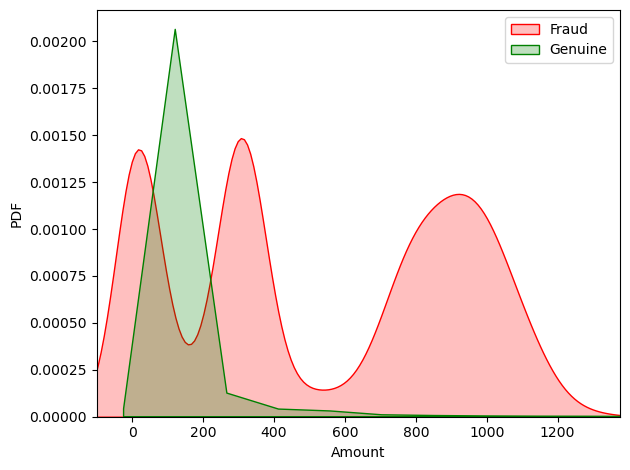

In [23]:
#checking the Transaction amount relevance with fraud
t_stat, p_value = stats.ttest_ind(data.loc[data['is_fraud']==0,'amt'],data.loc[data['is_fraud']==1,'amt'],equal_var=False)
print(f'Test statistic: {t_stat}')
print(f'p-value: {p_value}')
if p_value<0.05:
    print("There is significant difference in mean amt between fraud and genuine")
else:
    print("There is no significant difference in mean amt between fraud and genuine")
#Distribution of transaction amount with fradulent
sns.kdeplot(data.loc[data['is_fraud']==1,'amt'],fill=True,label="Fraud",color="red")
sns.kdeplot(data.loc[data['is_fraud']==0,'amt'],fill=True,label="Genuine",color="green")
plt.xlabel("Amount")
plt.ylabel("PDF")
plt.xlim(-100,data.loc[data['is_fraud']==1,'amt'].max())
plt.legend()
plt.tight_layout()


Test statistic: -13.572028811336757
p-value: 1.3998201786210887e-41
There is significant difference in mean ages between fraud and genuine


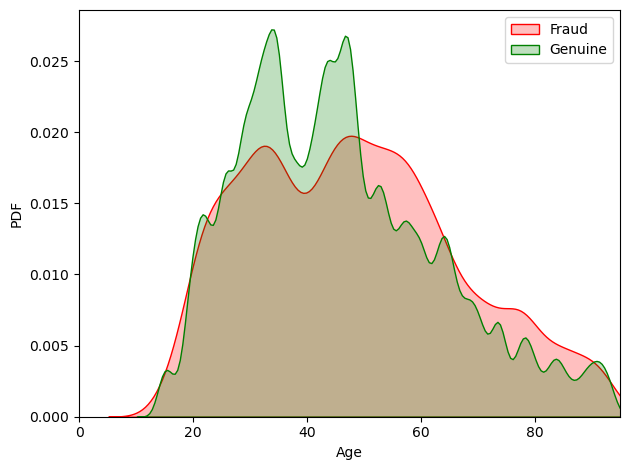

In [24]:
#checking the age group relevance with fraud
t_stat, p_value = stats.ttest_ind(data.loc[data['is_fraud']==0,'age'],data.loc[data['is_fraud']==1,'age'],equal_var=False)
print(f'Test statistic: {t_stat}')
print(f'p-value: {p_value}')
if p_value<0.05:
    print("There is significant difference in mean ages between fraud and genuine")
else:
    print("There is no significant difference in mean ages between fraud and genuine")
#Age PDF with respect to fraud and genuine
sns.kdeplot(data.loc[data['is_fraud']==1,'age'],fill=True,label="Fraud",color="red")
sns.kdeplot(data.loc[data['is_fraud']==0,'age'],fill=True,label="Genuine",color="green")
plt.xlabel("Age")
plt.ylabel("PDF")
plt.xlim(0,data.loc[data['is_fraud']==1,'age'].max())
plt.legend()
plt.tight_layout()

In [25]:
# #calculation of distance between merchant and customer and check its relevance with fraud or genuine
# cord1=list(zip(data['lat'],data['long']))
# cord2=list(zip(data['merch_lat'],data['merch_long']))

# list_distance=[]
# for p1,p2 in zip(cord1,cord2):
#     distance= geodesic(p1,p2).kilometers
#     list_distance.append(distance)
# data['distance']=list_distance
# data['distance'].head(5)


In [26]:
# #checking the distance relevance with fraud
# t_stat, p_value = stats.ttest_ind(data.loc[data['is_fraud']==0,'distance'],data.loc[data['is_fraud']==1,'distance'],equal_var=True)
# print(f'Test statistic: {t_stat}')
# print(f'p-value: {p_value}')
# if p_value<0.05:
#     print("There is significant difference in mean distances between fraud and genuine")
# else:
#     print("There is no significant difference in mean distances between fraud and genuine")
# #Age PDF with respect to fraud and genuine
# sns.kdeplot(data.loc[data['is_fraud']==1,'distance'],fill=True,label="Fraud",color="red")
# sns.kdeplot(data.loc[data['is_fraud']==0,'distance'],fill=True,label="Genuine",color="green")
# plt.xlabel("distance")
# plt.ylabel("PDF")
# plt.xlim(0,data.loc[data['is_fraud']==1,'distance'].max())
# plt.legend()
# plt.tight_layout()


Test_statistics:-0.4425980984768114
Test_statistics:0.6580565120915358
There is no significant difference in mean population between fraud and genuine


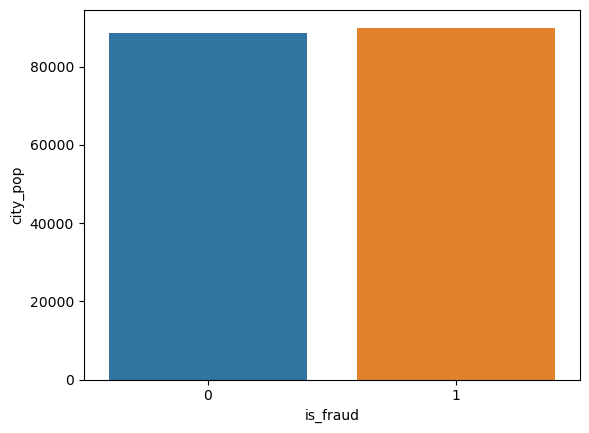

In [27]:
#checking population relevance with fradulent
t_stat, p_value = stats.ttest_ind(data.loc[data['is_fraud']==0,'city_pop'],data.loc[data['is_fraud']==1,'city_pop'],equal_var=True)
print(f"Test_statistics:{t_stat}")
print(f"Test_statistics:{p_value}")
if p_value<0.05:
    print("There is significant difference in mean population between fraud and genuine")
else:
    print("There is no significant difference in mean population between fraud and genuine")
    
sns.barplot(data=data,x='is_fraud',y='city_pop',ci=None)
plt.show()

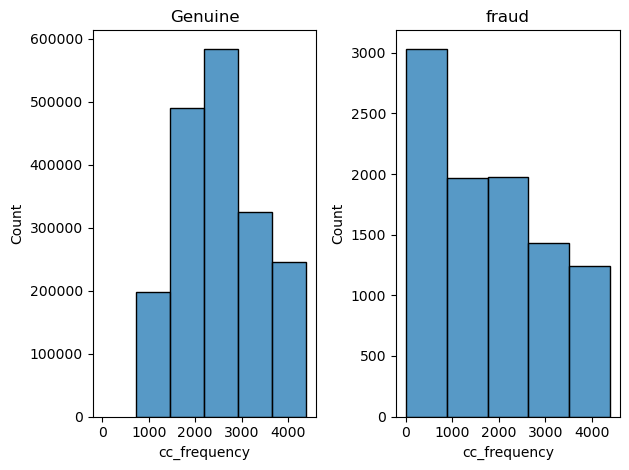

In [28]:
#checking the frequency of the cards 
data['cc_frequency']=data["cc_num"].map(data["cc_num"].value_counts())
fig,axs= plt.subplots(1,2,sharex=True)
sns.histplot(data[data['is_fraud']==0]['cc_frequency'],bins=5,ax=axs[0])
axs[0].set_title("Genuine")
sns.histplot(data[data['is_fraud']==1]['cc_frequency'],bins=5,ax=axs[1])
axs[1].set_title("fraud")
plt.tight_layout()



### as the above histogram describes, the cards that are used less or that are new are more vulnerable to fraud


In [29]:
#checking population relevance with fradulent
t_stat, p_value = stats.ttest_ind(data.loc[data['is_fraud']==0,'cc_frequency'],data.loc[data['is_fraud']==1,'cc_frequency'],equal_var=True)
print(f"Test_statistics:{t_stat}")
print(f"Test_statistics:{p_value}")
if p_value<0.05:
    print("There is significant difference in mean frequency between fraud and genuine")
else:
    print("There is no significant difference in mean frequency between fraud and genuine")

Test_statistics:69.1268177275082
Test_statistics:0.0
There is significant difference in mean frequency between fraud and genuine


[4 6 1 2 3 5]


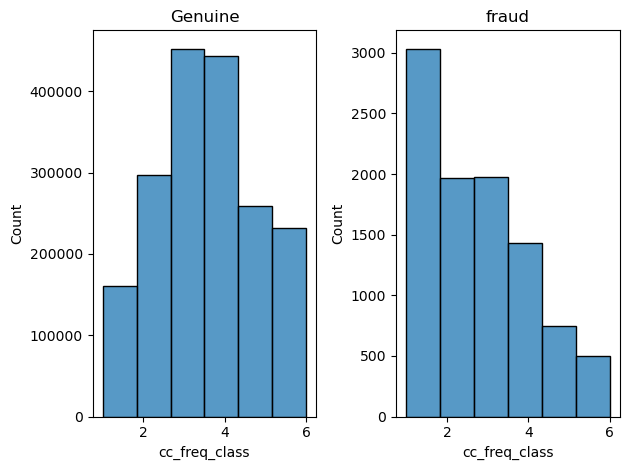

In [30]:
#converting these frequency in a class\
def classes(x):
    for idx,val in enumerate(list(range(800,5200,800))):
        if x < val:
            return idx+1
data['cc_freq_class'] = data['cc_frequency'].apply(classes)
print(data['cc_freq_class'].unique())

fig,axs= plt.subplots(1,2,sharex=True)
sns.histplot(data[data['is_fraud']==0]['cc_freq_class'],bins=6,ax=axs[0])
axs[0].set_title("Genuine")
sns.histplot(data[data['is_fraud']==1]['cc_freq_class'],bins=6,ax=axs[1])
axs[1].set_title("fraud")
plt.tight_layout()

In [31]:
#calculating the time difference between two consequtive transaction of a particular credit card
#data is sorted so that so that there is no any negative 'time_difference_hours'
sorted_data=data.sort_values(['cc_num', 'trans_date_trans_time'])
# data['time_difference_hours'] = ((sorted_date.groupby('cc_num')['trans_date_trans_time'].diff()).dt.total_seconds() / 3600)
sorted_data['time_difference_hours'] = ((sorted_data.groupby('cc_num')['trans_date_trans_time'].diff()).dt.total_seconds() / 3600)
sorted_data.loc[sorted_data['time_difference_hours'].isna(),'time_difference_hours']=0
sorted_data['time_difference_hours'].astype(int)
data = pd.merge(data, sorted_data[['cc_num', 'trans_date_trans_time', 'time_difference_hours']], on=['cc_num', 'trans_date_trans_time'], how='left')

In [32]:
#checking population relevance with fradulent
t_stat, p_value = stats.ttest_ind(data.loc[data['is_fraud']==0,'time_difference_hours'],data.loc[data['is_fraud']==1,'time_difference_hours'],equal_var=True)
print(f"Test_statistics:{t_stat}")
print(f"Test_statistics:{p_value}")
if p_value<0.05:
    print("There is significant difference in mean frequency between fraud and genuine")
else:
    print("There is no significant difference in mean frequency between fraud and genuine")

Test_statistics:21.723404400838714
Test_statistics:1.2707237059494032e-104
There is significant difference in mean frequency between fraud and genuine


In [33]:
#dropping the unncessary_columns
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1852482 entries, 0 to 1852481
Data columns (total 34 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Unnamed: 0             int64         
 1   trans_date_trans_time  datetime64[ns]
 2   cc_num                 int64         
 3   merchant               object        
 4   category               object        
 5   amt                    float64       
 6   first                  object        
 7   last                   object        
 8   gender                 object        
 9   street                 object        
 10  city                   object        
 11  state                  object        
 12  zip                    int64         
 13  lat                    float64       
 14  long                   float64       
 15  city_pop               int64         
 16  job                    object        
 17  dob                    datetime64[ns]
 18  trans_num             

In [34]:
#Dropping unnecessary columns
data.drop(columns=['Unnamed: 0','trans_date_trans_time','cc_num','first','last','street','state','zip','lat','long','city_pop','dob','trans_num','unix_time','merch_lat','merch_long','year','day','name_of_day'],inplace=True)

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1852482 entries, 0 to 1852481
Data columns (total 15 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   merchant               object 
 1   category               object 
 2   amt                    float64
 3   gender                 object 
 4   city                   object 
 5   job                    object 
 6   is_fraud               int64  
 7   split                  object 
 8   age                    float64
 9   month                  int64  
 10  hour                   int64  
 11  week_day               int64  
 12  cc_frequency           int64  
 13  cc_freq_class          int64  
 14  time_difference_hours  float64
dtypes: float64(3), int64(6), object(6)
memory usage: 226.1+ MB


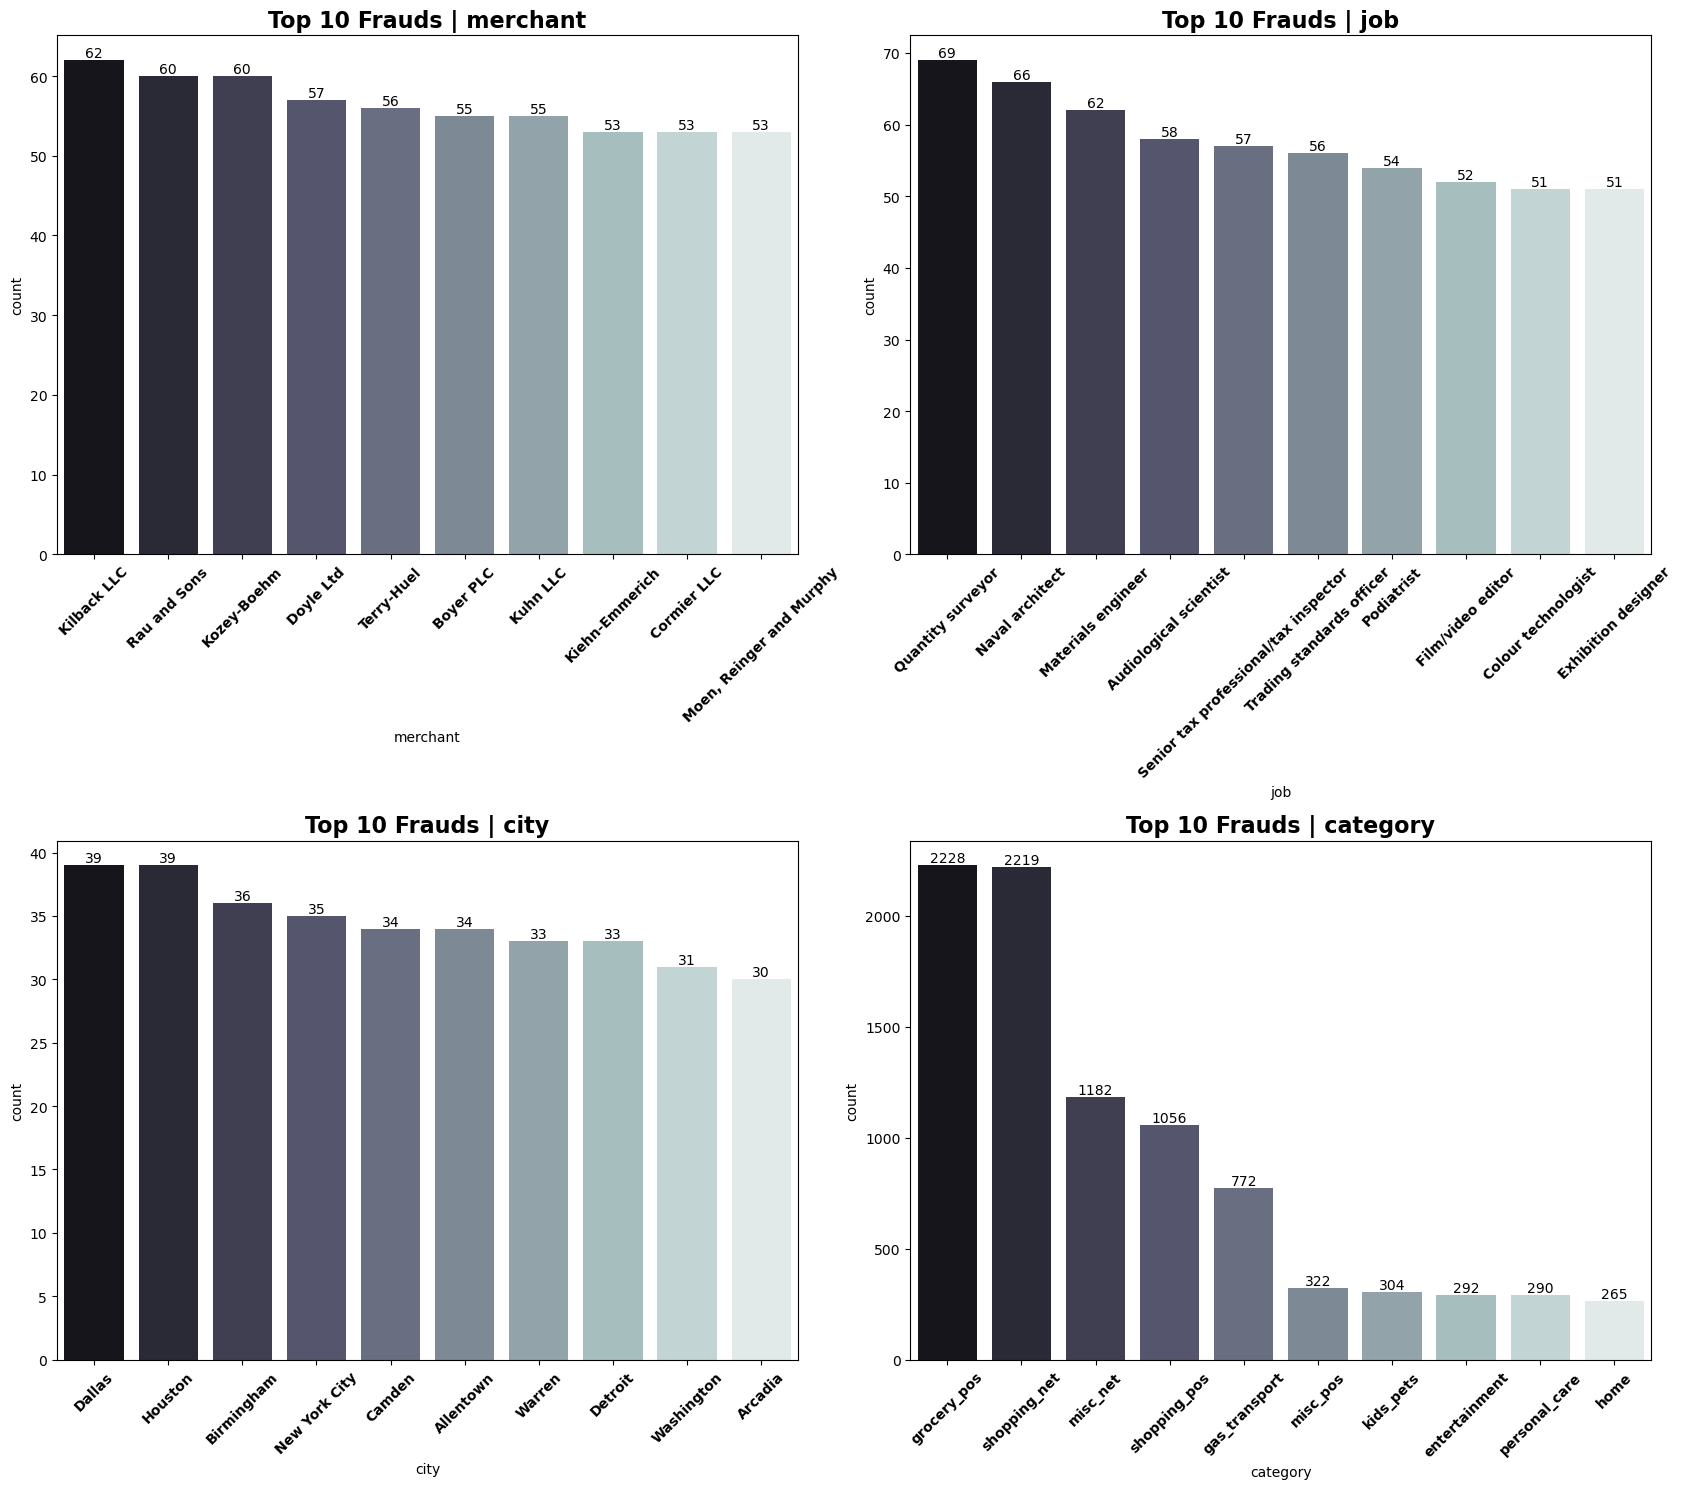

In [36]:
def bar_plot(col):
    top_frauds_data = data[data['is_fraud'] == 1][col].value_counts().head(10).reset_index()
    top_frauds_data.columns = [col, 'count']

    ax = sns.barplot(data=top_frauds_data, x=col, y='count', palette='bone')
    ax.bar_label(ax.containers[0])
    plt.title(f'Top 10 Frauds | {col}', fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, fontweight='bold')

plt.figure(figsize=(17, 15))

fraud_columns = ['merchant', 'job', 'city', 'category']

for idx, col in enumerate(fraud_columns, start=1):
    plt.subplot(2, 2, idx)
    bar_plot(col)

plt.tight_layout()
plt.show()

# Dealing with Categorical data and encoding it

In [37]:
#One hot encoding for gender
data=pd.get_dummies(data,columns=['gender'],drop_first=True)
data.head()


,merchant,category,amt,city,job,is_fraud,split,age,month,hour,week_day,cc_frequency,cc_freq_class,time_difference_hours,gender_M
0,"Rippin, Kub and Mann",misc_net,4.97,Moravian Falls,"Psychologist, counselling",0,train,30.0,1,0,1,2927,4,0.0,0
1,"Heller, Gutmann and Zieme",grocery_pos,107.23,Orient,Special educational needs teacher,0,train,40.0,1,0,1,4362,6,0.0,0
2,Lind-Buckridge,entertainment,220.11,Malad City,Nature conservation officer,0,train,56.0,1,0,1,735,1,0.0,1
3,"Kutch, Hermiston and Farrell",gas_transport,45.00,Boulder,Patent attorney,0,train,51.0,1,0,1,743,1,0.0,1
4,Keeling-Crist,misc_pos,41.96,Doe Hill,Dance movement psychotherapist,0,train,32.0,1,0,1,2922,4,0.0,1


In [38]:
# Function to perform k-fold encoding
# we use n_splits >2 to ensure every unique feature of every colums get included in groups. 
def kfold_encoding(data, cat_variable, target_variable, n_splits=4):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    data[cat_variable + '_e'] = pd.Series(dtype='float64')

    for train_index, test_index in kf.split(data):
        mean_encoding = data.iloc[train_index].groupby(cat_variable)[target_variable].mean()
        data.loc[test_index, cat_variable + '_e'] = data.loc[test_index, cat_variable].map(mean_encoding)

# Apply k-fold encoding to each categorical variable
categorical_variables = ['merchant', 'category', 'city', 'job']
target_variable = 'is_fraud'

for cat_var in categorical_variables:
    kfold_encoding(data, cat_var, target_variable)

In [39]:
data.drop(columns=categorical_variables,inplace=True)
data.head(5)

,amt,is_fraud,split,age,month,hour,week_day,cc_frequency,cc_freq_class,time_difference_hours,gender_M,merchant_e,category_e,city_e,job_e
0,4.97,0,train,30.0,1,0,1,2927,4,0.0,0,0.013636,0.013000,0.004572,0.003649
1,107.23,0,train,40.0,1,0,1,4362,6,0.0,0,0.010650,0.012700,0.002088,0.002186
2,220.11,0,train,56.0,1,0,1,735,1,0.0,1,0.002051,0.002136,0.008621,0.020443
3,45.00,0,train,51.0,1,0,1,743,1,0.0,1,0.002528,0.004116,0.019366,0.005476
4,41.96,0,train,32.0,1,0,1,2922,4,0.0,1,0.003509,0.002912,0.004159,0.004159


In [40]:
print(data.isna().sum())

amt                      0
is_fraud                 0
split                    0
age                      0
month                    0
hour                     0
week_day                 0
cc_frequency             0
cc_freq_class            0
time_difference_hours    0
gender_M                 0
merchant_e               0
category_e               0
city_e                   0
job_e                    0
dtype: int64


# checking outliners (we check outliners for only amount,frequency and time_difference)

In [41]:
x_train=data[data['split']=='train'].drop(columns=(['split','is_fraud']),axis=1)
y_train=data[data['split']=='train']['is_fraud']
x_test=data[data['split']=='test'].drop(columns=(['split','is_fraud']),axis=1)
y_test=data[data['split']=='test']['is_fraud']

In [42]:
y_train.head(5)

0    0
1    0
2    0
3    0
4    0
Name: is_fraud, dtype: int64

C:\Users\nepal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\nepal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


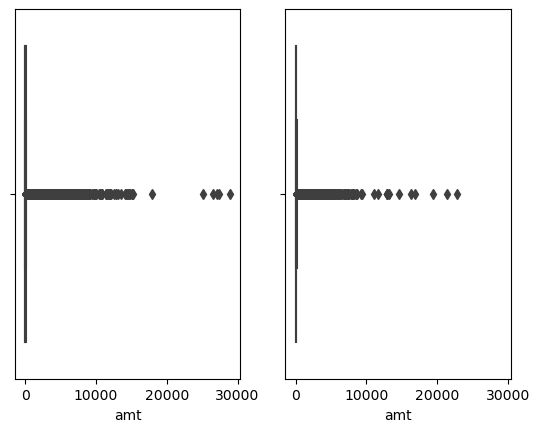

<Figure size 500x1500 with 0 Axes>

In [43]:
# checking outliners
fig,axs= plt.subplots(1,2,sharex=True)
plt.figure(figsize=(5,15))
sns.boxplot(x_train['amt'],ax=axs[0])
sns.boxplot(x_test['amt'],ax=axs[1])
# sns.boxplot(x_train['time_difference_hours'],ax=axs[1,0])
# sns.boxplot(x_test['time_difference_hours'],ax=axs[1,1])
# sns.boxplot(x_train['cc_frequency'],ax=axs[2,0])
# sns.boxplot(x_test['cc_frequency'],ax=axs[2,1])
plt.show()


C:\Users\nepal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\nepal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


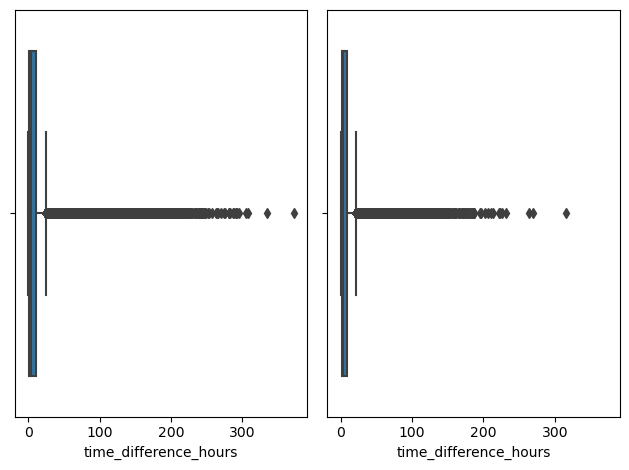

In [44]:
fig,axs= plt.subplots(1,2,sharex=True)
sns.boxplot(x_train['time_difference_hours'],ax=axs[0])
sns.boxplot(x_test['time_difference_hours'],ax=axs[1])
plt.tight_layout()


C:\Users\nepal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\nepal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


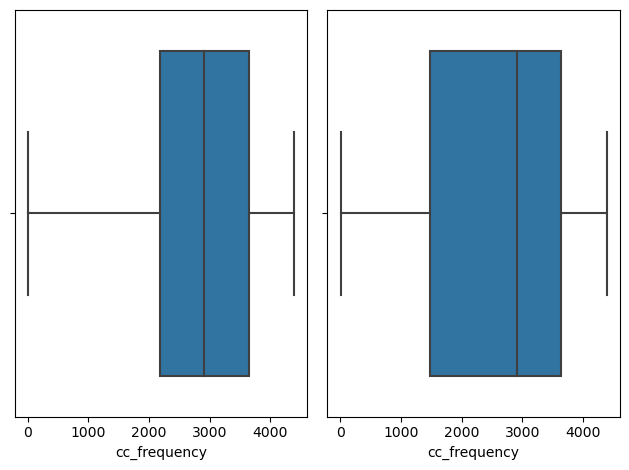

In [45]:
fig,axs= plt.subplots(1,2,sharex=True)
sns.boxplot(x_train['cc_frequency'],ax=axs[0])
sns.boxplot(x_test['cc_frequency'],ax=axs[1])
plt.tight_layout()


In [46]:
#transforming the outliers in amount and hours_difference using log
x_train['amt']=np.log1p(x_train['amt'])
x_train['time_difference_hours']=np.log1p(x_train['time_difference_hours'])
x_test['amt']=np.log1p(x_test['amt'])
x_test['time_difference_hours']=np.log1p(x_test['time_difference_hours'])

In [47]:
print(x_train.isnull().sum())
print('\n')
print(x_test.isnull().sum())

amt                      0
age                      0
month                    0
hour                     0
week_day                 0
cc_frequency             0
cc_freq_class            0
time_difference_hours    0
gender_M                 0
merchant_e               0
category_e               0
city_e                   0
job_e                    0
dtype: int64


amt                      0
age                      0
month                    0
hour                     0
week_day                 0
cc_frequency             0
cc_freq_class            0
time_difference_hours    0
gender_M                 0
merchant_e               0
category_e               0
city_e                   0
job_e                    0
dtype: int64


C:\Users\nepal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\nepal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


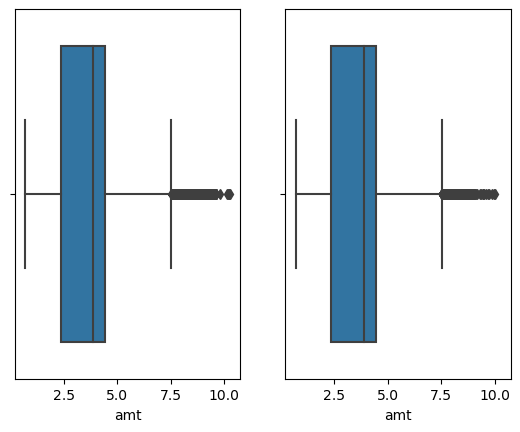

<Figure size 500x1500 with 0 Axes>

In [48]:
fig,axs= plt.subplots(1,2,sharex=True)
plt.figure(figsize=(5,15))
sns.boxplot(x_train['amt'],ax=axs[0])
sns.boxplot(x_test['amt'],ax=axs[1])
plt.show()

C:\Users\nepal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\nepal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


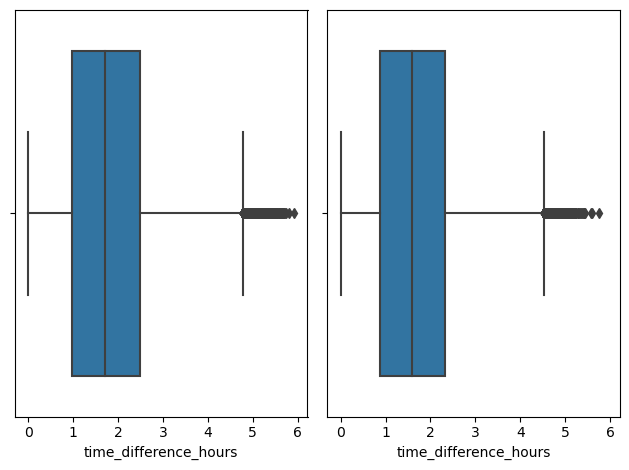

In [49]:
fig,axs= plt.subplots(1,2,sharex=True)
sns.boxplot(x_train['time_difference_hours'],ax=axs[0])
sns.boxplot(x_test['time_difference_hours'],ax=axs[1])
plt.tight_layout()


In [50]:
#checking total number of outliers repective to is_fraud==1,which remained still after transforming by log
def outliers(column, fraud):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)

    IQR = q3 - q1
    lower_bound = q1 - 1.5 * IQR
    upper_bound = q3 + 1.5 * IQR

    if fraud.any() == 1:
        outliers = (column < lower_bound) | (column > upper_bound)
        return outliers.sum()
    else:
        return 0

train_amt_outliers = outliers(x_train['amt'], y_train)
train_hour_diff_outliers = outliers(x_train['time_difference_hours'], y_train)
test_amt_outliers = outliers(x_test['amt'], y_train)
test_hour_diff_outliers = outliers(x_test['time_difference_hours'], y_train)

print(f'Total number of outliers in train "amt" column for fraud cases: {train_amt_outliers}')
print(f'Total number of outliers in train "time_difference_hours" column for fraud cases: {train_hour_diff_outliers}')
print(f'Total number of outliers in test "amt" column for fraud cases: {test_amt_outliers}')
print(f'Total number of outliers in test "time_difference_hours" column for fraud cases: {test_hour_diff_outliers}')


Total number of outliers in train "amt" column for fraud cases: 818
Total number of outliers in train "time_difference_hours" column for fraud cases: 1719
Total number of outliers in test "amt" column for fraud cases: 402
Total number of outliers in test "time_difference_hours" column for fraud cases: 1045


In [51]:
print((y_train==1).value_counts())
print((y_test==1).value_counts())

False    1289209
True        7506
Name: is_fraud, dtype: int64
False    553622
True       2145
Name: is_fraud, dtype: int64


In [52]:
# we have 7506 and 2145 fraud data in train and test set respectively. 
#The amount of outliers data for fraud data is 818 and 402 respectievly.
#so we can delete these outliers bcoz they are in less numbers and our number of data for fraud will not decrease drastically
def outliers(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)

    IQR = q3 - q1
    lower_bound = q1 - 1.5 * IQR
    upper_bound = q3 + 1.5 * IQR

    outliers = (column < lower_bound) | (column > upper_bound)
    return outliers
  
train_amt_outliers = outliers(x_train['amt'])
train_hour_diff_outliers = outliers(x_train['time_difference_hours'])
test_amt_outliers = outliers(x_test['amt'])
test_hour_diff_outliers = outliers(x_test['time_difference_hours'])

deleted_rows_train= (train_amt_outliers) | (train_hour_diff_outliers)
deleted_rows_test= (test_amt_outliers) | (test_hour_diff_outliers)

x_train=x_train[~deleted_rows_train]
x_test=x_test[~deleted_rows_test]
y_train=y_train[~deleted_rows_train]
y_test=y_test[~deleted_rows_test]


In [53]:
print(x_train.isnull().sum())
print(x_train.shape)
print(y_train.isnull().sum())
print(y_train.shape)
print('\n')
print(x_test.isnull().sum())
print(x_test.shape)
print(y_test.isnull().sum())
print(y_test.shape)


amt                      0
age                      0
month                    0
hour                     0
week_day                 0
cc_frequency             0
cc_freq_class            0
time_difference_hours    0
gender_M                 0
merchant_e               0
category_e               0
city_e                   0
job_e                    0
dtype: int64
(1294179, 13)
0
(1294179,)


amt                      0
age                      0
month                    0
hour                     0
week_day                 0
cc_frequency             0
cc_freq_class            0
time_difference_hours    0
gender_M                 0
merchant_e               0
category_e               0
city_e                   0
job_e                    0
dtype: int64
(554320, 13)
0
(554320,)


C:\Users\nepal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\nepal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\nepal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\nepal\anaconda3\lib\si

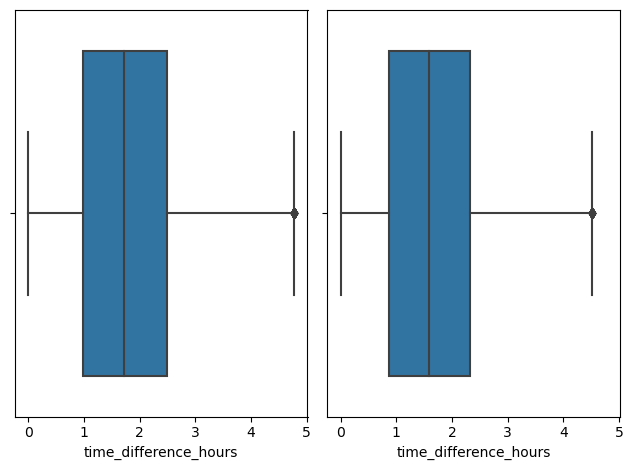

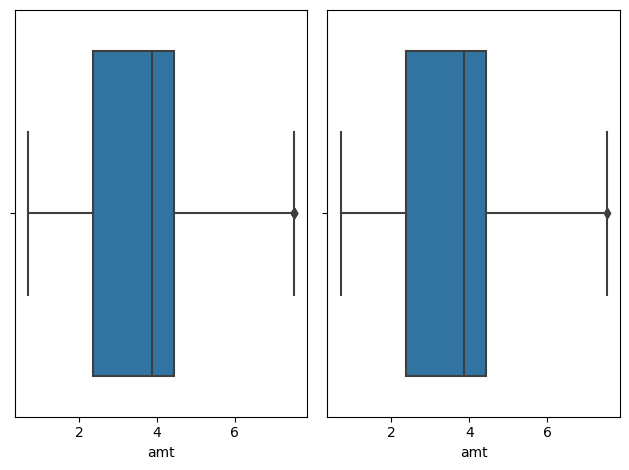

In [54]:
#check there are no outliners for our data
fig,axs= plt.subplots(1,2,sharex=True)
sns.boxplot(x_train['time_difference_hours'],ax=axs[0])
sns.boxplot(x_test['time_difference_hours'],ax=axs[1])
plt.tight_layout()

fig,axs= plt.subplots(1,2,sharex=True)
sns.boxplot(x_train['amt'],ax=axs[0])
sns.boxplot(x_test['amt'],ax=axs[1])
plt.tight_layout()

## For random forest, we don't need scaling

# Building Model


### Building model with imbalance dataset

In [ ]:
#finding best parameters for random forest classification Using Gridserachcv
#we use recall as scoring parameter to select grid, so that model doesnot miss out any no. of fraud dataset.
model=RandomForestClassifier(random_state=42)
crossvalidation=KFold(n_splits=5, shuffle=True, random_state=42)
parameters={'n_estimators':[100,150,200,250],
           'criterion':['gini','entropy','log_loss'],
           'max_depth':[10,12,15,20,25,30],
           }
Grid=GridSearchCV(model,param_grid=parameters,cv=crossvalidation,scoring='recall').fit(x_train,y_train)
print('Best_parameters: ',Grid.best_params_)
print('Best_score: ',Grid.best_score_)


In [ ]:
y_pred=Grid.predict(x_test)
print('test recall: 'recall_score(y_test,y_pred))
print('test precision: 'precision_score(y_test,y_pred))
print('test accuracy: 'accuracy(y_test,y_pred))
print('f1_score: 'f1_score(y_test,y_pred))
print('confusion matrix: 'confusion_matrix(y_test,y_pred))

## Building model by balancing the data using SMOTE (Oversampling)

In [ ]:
x=